In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import font_manager

%matplotlib inline

# 日本語フォントの設定
font_path = 'C:/Windows/Fonts/msgothic.ttc'  # MS Gothicフォントのパス
font_manager.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'MS Gothic'

In [28]:
#モデルの学習

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from shapely.wkt import loads
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, train_test_split
import shap
import optuna
from sklearn.metrics import confusion_matrix

class Train_model:
    def __init__(self, 
                 teacher_data_path,
                 target_usage,
                 model_output_path
                 ):
        self.teacher_data_path = teacher_data_path
        self.target_usage = target_usage
        self.X_train = None
        self.Y_train = None
        self.X_test = None
        self.Y_test = None
        self.teacher_data = None
        self.model_output_path = model_output_path

    def load_data(self):
        self.teacher_data = gpd.read_parquet(self.teacher_data_path)
    
    def target_variable(self):
        # 目的変数の追加
        self.teacher_data['target'] = self.teacher_data['usage'] == self.target_usage
        self.teacher_data['target'] = self.teacher_data['target'].astype(int)
    
    def clean_data(self):
        need_col = ['年少人口', '生産年齢人口', '老年人口', 
                    '出生時から', '1年未満', '1年以上5年未満', '5年以上10年未満',
                    '10年以上20年未満', '20年以上', '01_500万円未満', '07_500～1000万円未満','09_1000以上',
                    '一戸建', '長屋建', '共同住宅',
                    
                    'area', 'rectangularity', 'convexity',
                    'moment_of_inertia', 'num_corners', 'anisotropy', 'longest_axis',
                    'elongation', 'orientation', 
                    'target']
        
        self.teacher_data = self.teacher_data[need_col]

    def prepare_train(self):
        df = self.teacher_data.copy()
        
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(
            df.drop(columns='target'), df["target"], test_size=0.3, random_state=1
        )
        
    def objective(self, trial):
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'eta': trial.suggest_loguniform('eta', 0.01, 0.5),
            'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
            'seed': 42
        }

        # 交差検証
        kf = KFold(n_splits=3, shuffle=True, random_state=42)
        f1_list = []
        for fold, (train_index, val_index) in enumerate(kf.split(self.X_train)):
            X_train_fold, X_val_fold = self.X_train.iloc[train_index], self.X_train.iloc[val_index]
            y_train_fold, y_val_fold = self.Y_train.iloc[train_index], self.Y_train.iloc[val_index]
            
            # DMatrix形式に変換
            dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
            dval = xgb.DMatrix(X_val_fold, label=y_val_fold)

            # モデルを学習
            evals = [(dtrain, 'train'), (dval, 'eval')]
            model = xgb.train(params, dtrain, num_boost_round=100, evals=evals,
                              early_stopping_rounds=10, verbose_eval=False)

            preds_proba = model.predict(dval)
            preds = (preds_proba >= 0.5).astype(int)

            f1 = f1_score(y_val_fold, preds)
            f1_list.append(f1)

        return np.mean(f1_list)

    # モデルを最適化する関数
    def optimize_xgb_with_optuna(self):
        # Optunaのstudyを作成
        study = optuna.create_study(direction='maximize')
        study.optimize(lambda trial: self.objective(trial), n_trials=50)
        best_params = study.best_trial.params
        
        # 最適なハイパーパラメータを表示
        print('Best trial: ', best_params)

        # 最適なハイパーパラメータで最終モデルをトレーニング
        models = []

        # 各foldの予測精度を格納するリスト
        accuracy_list = []
        precision_list = []
        recall_list = []
        f1_list = []

        # feature importancesを格納するDataFrame
        feature_importances_df = pd.DataFrame()

        # 追加: 最も高いF1スコアとそのモデルを追跡するための変数
        best_f1_score_overall = -1.0 # F1スコアの初期値は-1.0 (最小値)
        best_f1_model = None # 最も良いモデルを格納する変数

        #交差検証
        kf = KFold(n_splits=3, shuffle=True, random_state=42)
        for fold, (train_index, val_index) in enumerate(kf.split(self.X_train)):
            x_train_fold, x_val_fold = self.X_train.iloc[train_index], self.X_train.iloc[val_index]
            y_train_fold, y_val_fold = self.Y_train.iloc[train_index], self.Y_train.iloc[val_index]

            # DMatrix形式に変換
            dtrain = xgb.DMatrix(x_train_fold, label=y_train_fold)
            dval = xgb.DMatrix(x_val_fold, label=y_val_fold)
            dtest = xgb.DMatrix(self.X_test, label=self.Y_test) 

            # モデルを学習
            model = xgb.train(best_params, dtrain, num_boost_round=100, evals=[(dtrain, 'train'), (dval, 'eval')],
                              early_stopping_rounds=10, verbose_eval=False)
            
            # 検証データ(validation data)で最適な閾値を探す
            val_preds_proba = model.predict(dval)
            best_threshold = 0
            best_f1 = 0
            # 0.01から0.99まで0.01刻みで閾値を試す
            for threshold in np.arange(0.01, 1.0, 0.01):
                val_preds = (val_preds_proba >= threshold).astype(int)
                f1 = f1_score(y_val_fold, val_preds)
                if f1 > best_f1:
                    best_f1 = f1
                    best_threshold = threshold

            print(f"Fold {fold + 1} - Found Best Threshold: {best_threshold:.2f} (with F1 score: {best_f1:.4f} on validation set)")
            
            # feature importancesを取得
            feature_importances = pd.DataFrame()
            feature_importances["feature"] = self.X_train.columns
            # XGBoostの特徴量重要度を取得し、存在しない特徴量の重要度を0に設定
            importance_dict = model.get_score(importance_type='weight')
            feature_importances["importance"] = feature_importances["feature"].map(importance_dict).fillna(0)
            feature_importances["fold"] = fold
            feature_importances_df = pd.concat([feature_importances_df, feature_importances], axis=0)

            preds_proba = model.predict(dtest)

            # 予測結果を取得（さきほど見つけた最適な閾値を使用）
            preds = (preds_proba >= best_threshold).astype(int)

            print("=" * 50)
            print(f"Start of Fold {fold + 1}")

            accuracy = accuracy_score(self.Y_test, preds)
            precision = precision_score(self.Y_test, preds)
            recall = recall_score(self.Y_test, preds)
            f1 = f1_score(self.Y_test, preds)

            # 追加: 最も高いF1スコアを持つモデルを更新
            if f1 > best_f1_score_overall:
                best_f1_score_overall = f1
                best_f1_model = model # モデルオブジェクトを保存
                print(f"  New best F1 score found: {best_f1_score_overall:.4f} in Fold {fold + 1}")

            # 混同行列を取得して先に表示（数値）
            cm = confusion_matrix(self.Y_test, preds)
            cm_float = cm.astype(float)
            print(f"Fold {fold + 1} - Confusion Matrix (Precise Values):\n{cm_float}")
            
            # 表示
            print("\n===== 最適化されたハイパーパラメータ =====")
            for key, val in best_params.items():
                print(f"  {key}: {val}")


            print("\n===== 最適な閾値 =====")
            print(f"  Best Threshold: {best_threshold:.2f}")
            
            # スコアも表示
            print("\n===== スコア =====")
            print(f"Fold {fold + 1} - Test Set Results:")
            print(f"Accuracy: {accuracy:.3f}")
            print(f"Precision: {precision:.3f}")
            print(f"Recall: {recall:.3f}")
            print(f"F1 Score: {f1:.3f}")
            print("-" * 40)

            # プロットは最後に            
            plt.figure(figsize=(6, 5))
            sns.heatmap(cm_float, annot=True, fmt=".10g", cmap='Blues')
            plt.title(f"Confusion Matrix - Fold {fold + 1}")
            plt.xlabel("Predicted Label")
            plt.ylabel("True Label")
            plt.show()
            
            print(f"End of Fold {fold + 1}")
            print("=" * 50)
            
            models.append(model)

        # 追加: 交差検証ループ終了後に、最もF1スコアが高かったモデルを保存
        if best_f1_model is not None:
            best_f1_model.save_model(self.model_output_path)
            print(f"modelのセーブ完了")
        else:
            print("\nNo model was saved (best_f1_model is None).")

        mean_feature_importances = feature_importances_df.groupby("feature")["importance"].mean().reset_index()
        mean_feature_importances = mean_feature_importances.sort_values(by="importance", ascending=False)
        
        plt.figure(figsize=(16, 10))
        mean_feature_importances_20 = mean_feature_importances
        sns.barplot(x="importance", y="feature", data=mean_feature_importances_20, palette="viridis")
        plt.xlabel("重要度", fontsize=20)
        plt.ylabel("特徴量", fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.title("Mean Feature Importances (Top 20)", fontsize=22)
        plt.grid(True, linestyle='--', zorder=0)
        plt.tight_layout()
        plt.show()
        print('次のfoldに移行中')
        
        if models:
            explainer = shap.TreeExplainer(models[0])
            shap_values = explainer.shap_values(self.X_test)
            shap_df = pd.DataFrame(shap_values, columns=self.X_test.columns)
            top_10_features = shap_df.abs().mean().sort_values(ascending=False).head(10).index.tolist()
            shap.summary_plot(shap_df[top_10_features].values, self.X_test[top_10_features], plot_type='dot', show=False)
        else:
            print("No models were trained for SHAP value calculation.")

        print('次のfoldに移行中')

    def run(self):
        self.load_data()
        self.target_variable()
        self.clean_data()
        self.prepare_train()
        self.optimize_xgb_with_optuna()

[I 2025-07-17 17:49:11,841] A new study created in memory with name: no-name-57e70685-a394-4747-91b1-3e430bcb3f83
C:\Users\0141s\AppData\Local\Temp\ipykernel_34632\6137585.py:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 0.01, 0.5),
C:\Users\0141s\AppData\Local\Temp\ipykernel_34632\6137585.py:67: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\0141s\AppData\Local\Temp\ipykernel_34632\6137585.py:68: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead

Best trial:  {'max_depth': 10, 'eta': 0.04333726698158826, 'subsample': 0.9673199949572634, 'colsample_bytree': 0.9254938630124476}
Fold 1 - Found Best Threshold: 0.36 (with F1 score: 0.8096 on validation set)
Start of Fold 1
  New best F1 score found: 0.8078 in Fold 1
Fold 1 - Confusion Matrix (Precise Values):
[[14397.  9172.]
 [  859. 21078.]]

===== 最適化されたハイパーパラメータ =====
  max_depth: 10
  eta: 0.04333726698158826
  subsample: 0.9673199949572634
  colsample_bytree: 0.9254938630124476

===== 最適な閾値 =====
  Best Threshold: 0.36

===== スコア =====
Fold 1 - Test Set Results:
Accuracy: 0.780
Precision: 0.697
Recall: 0.961
F1 Score: 0.808
----------------------------------------


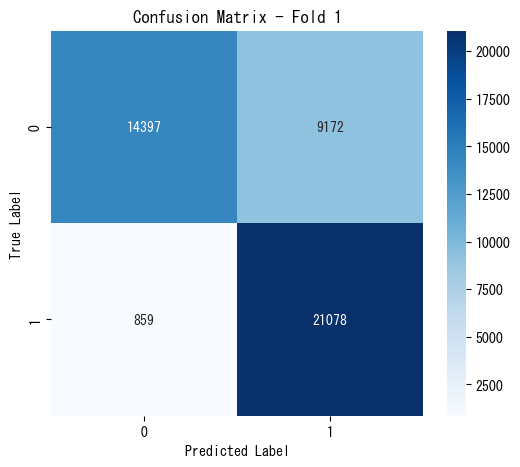

End of Fold 1
Fold 2 - Found Best Threshold: 0.38 (with F1 score: 0.8070 on validation set)
Start of Fold 2
  New best F1 score found: 0.8081 in Fold 2
Fold 2 - Confusion Matrix (Precise Values):
[[14567.  9002.]
 [  959. 20978.]]

===== 最適化されたハイパーパラメータ =====
  max_depth: 10
  eta: 0.04333726698158826
  subsample: 0.9673199949572634
  colsample_bytree: 0.9254938630124476

===== 最適な閾値 =====
  Best Threshold: 0.38

===== スコア =====
Fold 2 - Test Set Results:
Accuracy: 0.781
Precision: 0.700
Recall: 0.956
F1 Score: 0.808
----------------------------------------


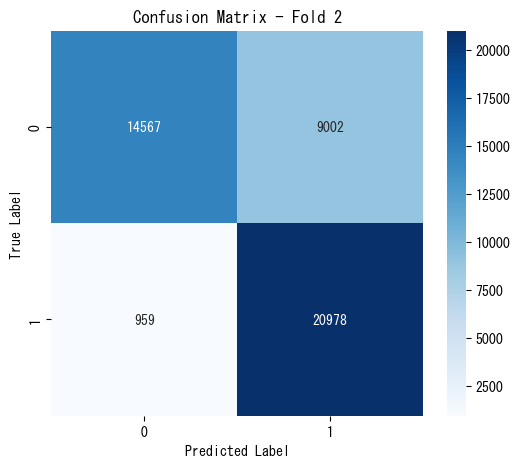

End of Fold 2
Fold 3 - Found Best Threshold: 0.37 (with F1 score: 0.8109 on validation set)
Start of Fold 3
  New best F1 score found: 0.8096 in Fold 3
Fold 3 - Confusion Matrix (Precise Values):
[[14572.  8997.]
 [  900. 21037.]]

===== 最適化されたハイパーパラメータ =====
  max_depth: 10
  eta: 0.04333726698158826
  subsample: 0.9673199949572634
  colsample_bytree: 0.9254938630124476

===== 最適な閾値 =====
  Best Threshold: 0.37

===== スコア =====
Fold 3 - Test Set Results:
Accuracy: 0.783
Precision: 0.700
Recall: 0.959
F1 Score: 0.810
----------------------------------------


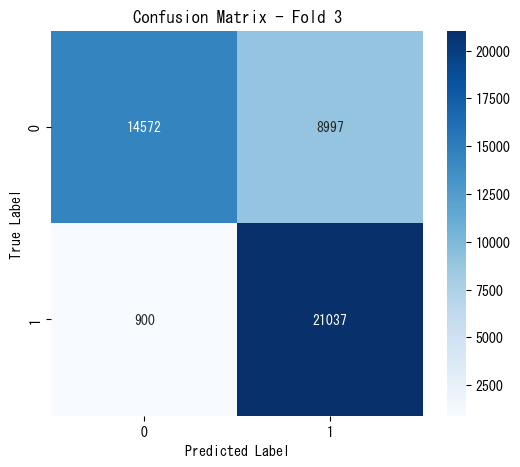

End of Fold 3
modelのセーブ完了


C:\Users\0141s\AppData\Local\Temp\ipykernel_34632\6137585.py:227: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=mean_feature_importances_20, palette="viridis")


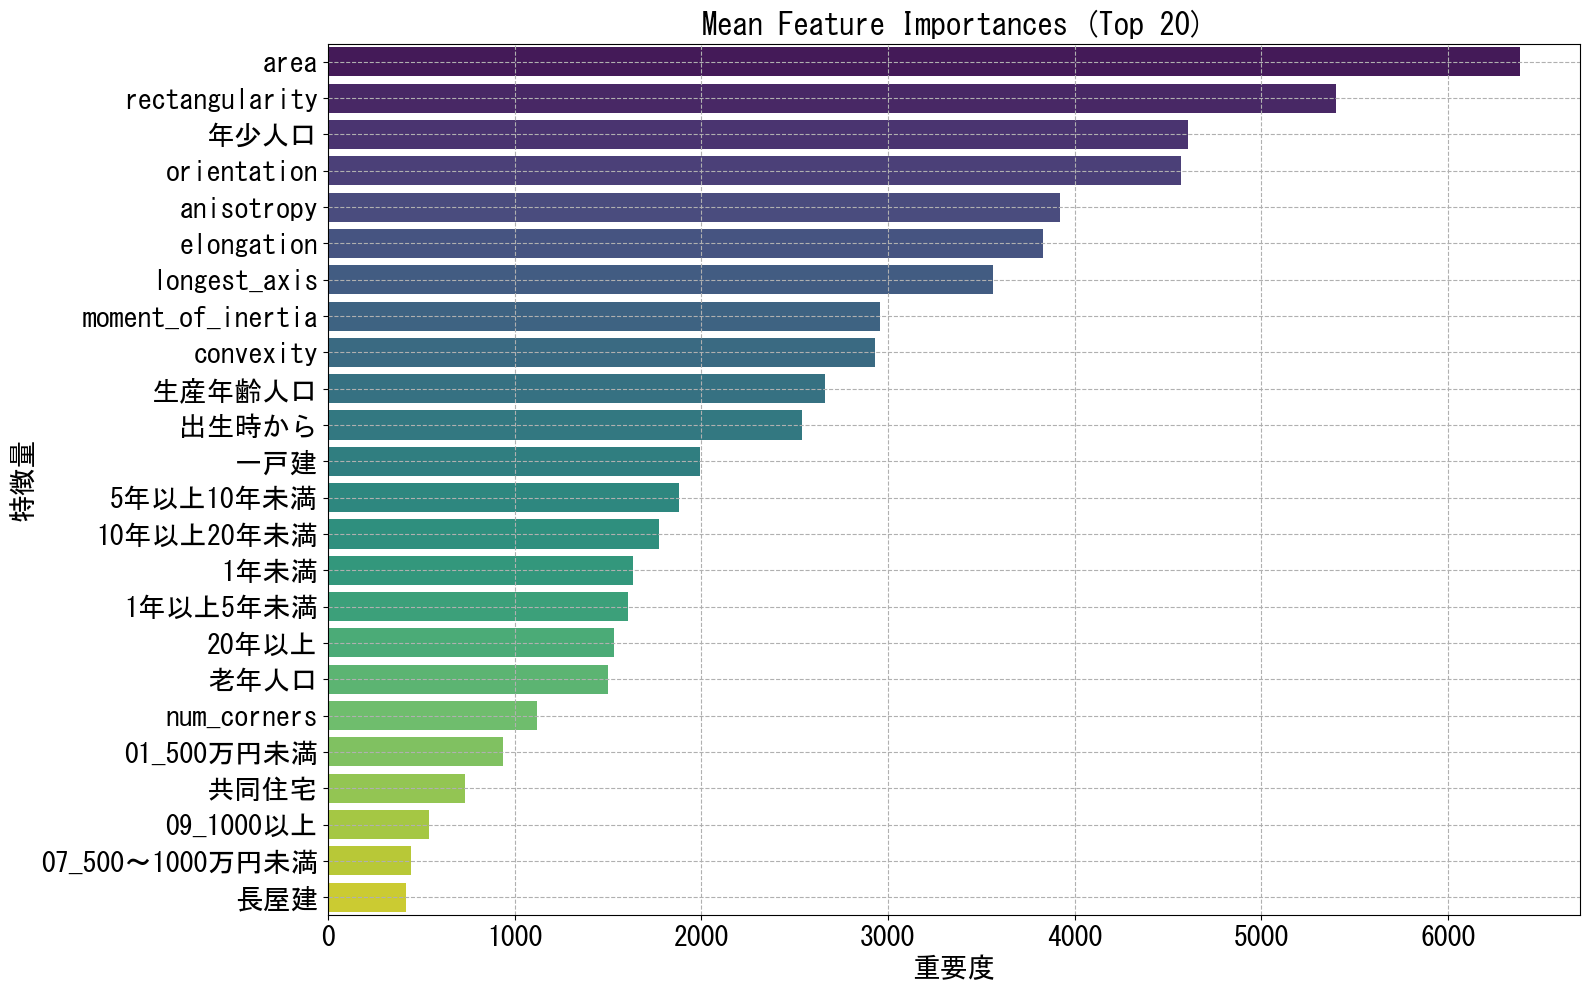

次のfoldに移行中
次のfoldに移行中


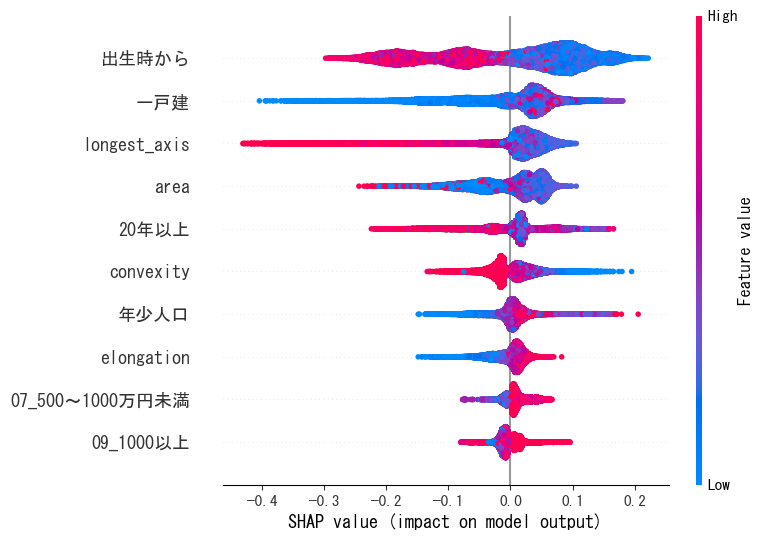

In [29]:
# 実行ファイル
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

if __name__ == "__main__":
    #教師データのパス
    teacher_data_path = "G:/マイドライブ/akiyamalab/オープン住宅地図/dev_2025/train/feature_engineering/detached/15202.parquet"
    target_usage = '411'
    model_output_path = "G:/マイドライブ/akiyamalab/オープン住宅地図/dev_2025/train/train_model/15202_detached.json"


    train_model = Train_model(teacher_data_path,
                              target_usage,
                              model_output_path
                             )
    
    train_model.run()

In [15]:
teacher_data = gpd.read_parquet(teacher_data_path)

In [17]:
teacher_data.columns

Index(['geometry', 'KEY_CODE', 'PREF_NAME', 'CITY_NAME', 'S_NAME', '年少人口',
       '生産年齢人口', '老年人口', '出生時から', '1年未満', '1年以上5年未満', '5年以上10年未満',
       '10年以上20年未満', '20年以上', '居住期間「不詳」', '00_総数', '01_500万円未満',
       '07_500～1000万円未満', '09_1000以上', '一戸建', '長屋建', '共同住宅', 'buildingID',
       'class', 'usage', 'area', 'perimeter', 'rectangularity', 'convexity',
       'moment_of_inertia', 'num_corners', 'anisotropy', 'longest_axis',
       'elongation', 'orientation', 'type_堅ろう建物', 'type_堅ろう無壁舎', 'type_普通建物',
       'type_普通無壁舎', 'unique_id', 'center', 'buffer', '1_amenity', '1_shop',
       '1_tourism', '3_amenity', '3_shop', '3_tourism', '5_amenity', '5_shop',
       '5_tourism'],
      dtype='object')

In [ ]:
plt.figure(figsize=(16, 10))
mean_feature_importances_20 = mean_feature_importances.head(20)
sns.barplot(x="importance", y="feature", data=mean_feature_importances_20, palette="viridis")
plt.xlabel("重要度", fontsize=20)
plt.ylabel("特徴量", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Mean Feature Importances (Top 20)", fontsize=22)
plt.grid(True, linestyle='--', zorder=0)
plt.tight_layout()
plt.show()
print('次のfoldに移行中')